In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
filepath = 'pCO2 ed. 3 Data File_20240520.csv'

In [3]:
def read_asp3_file(filepath: str) -> xr.Dataset:
   df = pd.read_csv(filepath,encoding = 'windows-1252', sep = ';',skiprows = 7)
   
   df['time'] = pd.to_datetime(df['Time (Local)']) # Convert time to something Pythonic.
   df.index = df.time
   ds = df.to_xarray() # Convert to an xarray.Dataset

   # Reformat data to be associated with a CO2 source.
   ds['Source'] = ds['Source'].astype(str)
   sources = np.unique(ds.Source)
   ds_list = []
   for source in sources:
      _ds = ds.where(ds.Source == source, drop = True)
      _ds = _ds.assign_coords({'Source':np.unique(_ds.Source)})
      ds_list.append(_ds)
   ds = xr.combine_by_coords(ds_list)

   # Rename variables and coords.
   _coords = ds.coords
   for _coord in _coords:
      new_coord_name = _coord.lower()
      new_coord_name= new_coord_name.split('(')[0]
      new_coord_name = new_coord_name.replace(' ','_')
      ds = ds.rename({_coord: new_coord_name})

   # Rename variables
   _vars = ds.data_vars
   for _var in _vars:
      _append = None
      new_var_name = _var.lower()
      if 'wind direction' in new_var_name:
         if '(t)' in new_var_name:
            _append = '_true'
         elif '(m)' in new_var_name:
            _append = '_mean'
      if 'barometric press' in new_var_name:
         if '[mda]' in new_var_name:
            _append = '_mda'
         elif '[xdr]' in new_var_name:
            _append = '_xdr'
      new_var_name = new_var_name.split('(')[0]
      new_var_name = new_var_name.replace(' ','_')
      if 'time' in new_var_name:
         _append = 'local'
      if _append is not None:
         new_var_name = new_var_name + _append    
      new_var_name = new_var_name.replace('.','')
      if new_var_name[-1] == '_':
         new_var_name = new_var_name[:-1]
      new_var_name = new_var_name.replace('/','_')
      new_var_name = new_var_name.replace('__','_')
      ds = ds.rename({_var: new_var_name})
   
   #Set Attributes
   ds.attrs['operator'] = np.unique(ds.operator)
   
   # Drop vars
   ds = ds.drop_vars(['operator'])
   
   
   # Reformat vars
   _vars = ['source','time_local','mode','note','overflow_alarm_shut-off_valve','number_of_measurements','measurement_interval','test_type']
   for _var in _vars:
      ds[_var] = ds[_var].astype(str)
   return ds

In [4]:
ds = read_asp3_file(filepath)


In [5]:
ds = read_asp3_file(filepath)
ds.to_netcdf('asp3_test_file.nc')

In [6]:
ds = xr.open_dataset('asp3_test_file.nc')

In [7]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                               (time: 524, source: 4)
Coordinates:
  * time                                  (time) datetime64[ns] 4kB 2024-05-2...
  * source                                (source) object 32B '2000.0 ppm SD-...
Data variables: (12/83)
    note                                  (source, time) object 17kB ...
    time_local                            (source, time) object 17kB ...
    test_type                             (source, time) object 17kB ...
    overflow_alarm_shut-off_valve         (source, time) object 17kB ...
    number_of_measurements                (source, time) object 17kB ...
    measurement_interval                  (source, time) object 17kB ...
    ...                                    ...
    weather_station_barometric_press_xdr  (source, time) float64 17kB ...
    li-7820_n2o                           (source, time) float64 17kB ...
    li-7820_h2o                           (source, time) float64 17kB ...
    li-7820_cavity_press                  (source, time) float64 17kB ...
    li-7820_cavity_temp                   (source, time) float64 17kB ...
    li-7820_diagnostic                    (source, time) float64 17kB ...
Attributes:
    operator:  nan

In [8]:
air = ds.sel(source = 'Air')
sw = ds.sel(source = 'Seawater')
s1 = ds.sel(source = '386.0 ppm SD-1')
s2 = ds.sel(source = '2000.0 ppm SD-2')

Text(0.5, 0, 'Datetime')

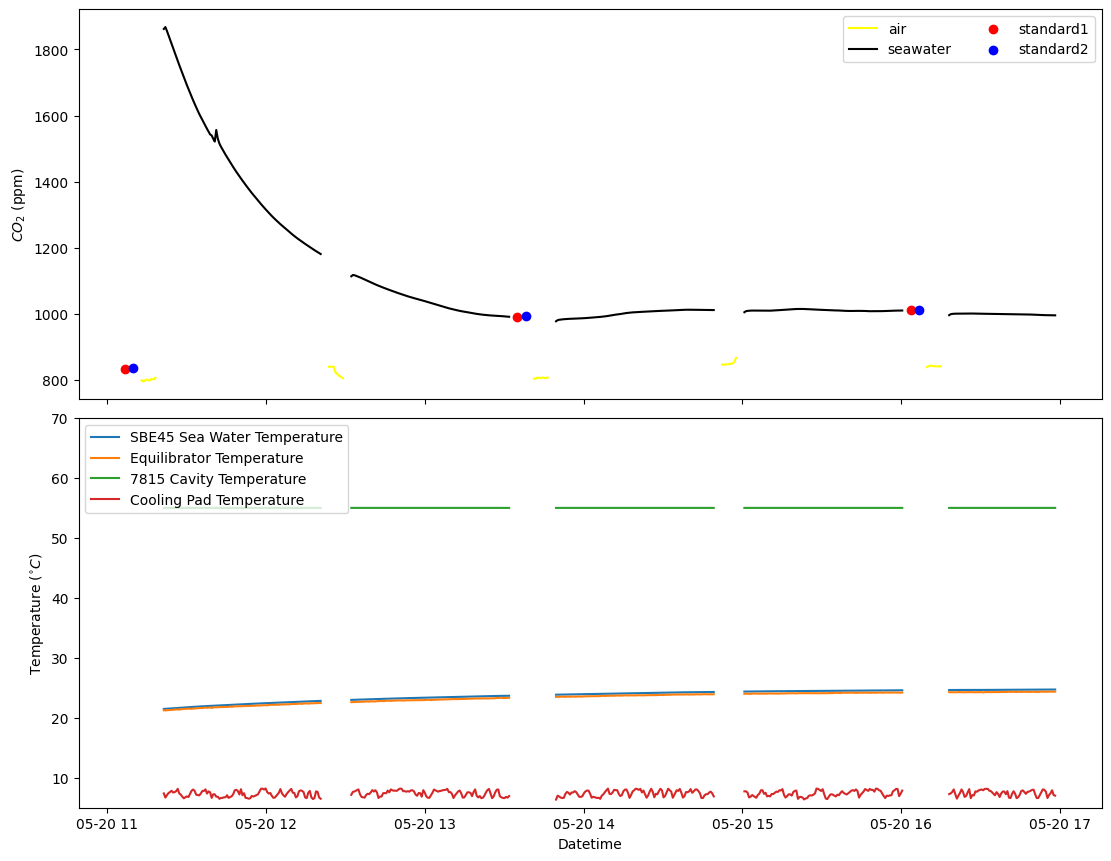

In [9]:
nrows = 2
ncols = 1

fig, ax = plt.subplots(nrows,ncols, figsize = (11,8.5), constrained_layout = True, sharex = True)
ax[0].plot(air.time, air['li-7815_co2'], color ='yellow', label = 'air')
ax[0].plot(sw.time, sw['li-7815_co2'], color = 'black', label = 'seawater')
ax[0].scatter(s1.time, s1['li-7815_co2'], color = 'red', label = 'standard1')
ax[0].scatter(s2.time, s2['li-7815_co2'], color = 'blue', label = 'standard2')

ax[0].legend(loc = 'upper right', ncol = 2)
ax[0].set_ylabel(r'$CO_2$ (ppm)')

ax[1].plot(sw.time, sw['sea-bird_water_temp'], label = 'SBE45 Sea Water Temperature')
ax[1].plot(sw.time, sw['equilibrator_temp'], label = 'Equilibrator Temperature')
ax[1].plot(sw.time, sw['li-7815_cavity_temp'], label = '7815 Cavity Temperature')
ax[1].plot(sw.time, sw['cooling_pad_temp'], label = 'Cooling Pad Temperature')
ax[1].set_ylim(5,70)
ax[1].legend(loc = 'upper left')
ax[1].set_ylabel(r'Temperature ($^{\circ}C$)')

ax[-1].set_xlabel('Datetime')